In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_core.tools import tool

In [5]:
# tool to get stock price
import yfinance as yf

@tool
def get_stock_price(symbol: str) -> float:
    """
    Get the stock price for a given stock symbol using Yahoo finance.
    """
    print(f"---Tool call executing for {symbol}---")
    ticker = yf.Ticker(symbol)

    # Fetch the stock's information. We use 'regularMarketPrice' for reliability, with a fallback.
    price = ticker.info.get('regularMarketPrice', ticker.info.get('currentPrice'))

    if price is None:
        return f"Could not find price for symbol {symbol}"
    return price

In [6]:
get_stock_price.invoke({"symbol": "NVDA"})

---Tool call executing for NVDA---


179.92

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(
        max_results=2
)

@tool
def get_recent_company_news(company_name: str) -> list:
    """Get recent news articles and summaries for a given company name using the Tavily search engine."""
    # We add a print statement for clear logging of tool execution.
    print(f"--- [Tool Call] Executing get_recent_company_news for: {company_name} ---")

    # We construct a more specific query for the search engine.
    query = f"latest news about {company_name}"
    
    # We invoke the underlying Tavily tool.
    return tavily_search.invoke(query)


In [9]:
get_recent_company_news.invoke({"company_name": "NVIDIA"})

--- [Tool Call] Executing get_recent_company_news for: NVIDIA ---


/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_64443/400374024.py:9: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(


[{'title': 'Latest News - NVIDIA Newsroom',
  'url': 'https://nvidianews.nvidia.com/news/latest',
  'content': '### The Largest Digital Zoo: Biology Model Trained on NVIDIA GPUs Identifies Over a Million Species\n\n### Ultimate Cloud Gaming Is Everywhere With GeForce NOW\n\n### NVIDIA Announces Financial Results for Third Quarter Fiscal 2026\n\n### Gordon Bell Prize Winners Push Open Science Boundaries With NVIDIA-Powered Supercomputers\n\n### Powering AI Superfactories, NVIDIA and Microsoft Integrate Latest Technologies for Inference, Cybersecurity, Physical AI [...] Autonomous Machines\nCloud & Data Center\nDeep Learning & Ai\nDesign & Pro Visualization\nHealthcare\nHigh Performance Computing\nSelf-Driving Cars\nGaming & Entertainment\n\n# Latest News\n\n### At NeurIPS, NVIDIA Advances Open Model Development for Digital and Physical AI\n\n### NVIDIA and Synopsys Announce Strategic Partnership to Revolutionize Engineering and Design\n\n### The Ultimate Black Friday Deal Is Here [...] 

The output, a list of recent news articles, confirms that our second tool is also working correctly. Our agent now has two distinct, real-world data-gathering capabilities.

To properly measure our performance improvements, we need to compile our workflow. We will update our graph state to include a field for logging performance metrics.

In [19]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langgraph.prebuilt import ToolNode

tools = [get_stock_price, get_recent_company_news]
tool_node = ToolNode(tools=tools, handle_tool_errors=True)

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)
llm_with_tools = llm.bind_tools(tools=tools)
print("Tools have been bound to the LLM.")
print(f"The model now has access to: {[tool.name for tool in tools]}")

Tools have been bound to the LLM.
The model now has access to: ['get_stock_price', 'get_recent_company_news']


In [20]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'get_stock_price': StructuredTool(name='get_stock_price', description='Get the stock price for a given stock symbol using Yahoo finance.', args_schema=<class 'langchain_core.utils.pydantic.get_stock_price'>, func=<function get_stock_price at 0x132a53e20>), 'get_recent_company_news': StructuredTool(name='get_recent_company_news', description='Get recent news articles and summaries for a given company name using the Tavily search engine.', args_schema=<class 'langchain_core.utils.pydantic.get_recent_company_news'>, func=<function get_recent_company_news at 0x162a7fce0>)}, tool_to_state_args={'get_stock_price': {}, 'get_recent_company_news': {}}, tool_to_store_arg={'get_stock_price': None, 'get_recent_company_news': None}, handle_tool_errors=True, messages_key='messages')

In [15]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    # 'performance_log' will accumulate strings detailing the execution time of each step
    performance_log: Annotated[List[str], add_messages]

Now, let’s create our first instrumented node, the agent “brain” that calls the LLM.

In [48]:
import time


def call_model(state: AgentState):
    print("--- AGENT: Invoking LLM --- ")
    start_time = time.time()

    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    print("Agent response:", response)

    end_time = time.time()
    execution_time = end_time - start_time

    # We create a log entry with the performance data.
    log_entry = f"[AGENT] LLM call took {execution_time:.2f} seconds."
    print(log_entry)
    
    # We return the LLM's response and the new log entry to be added to the state.
    return {
        "messages": [response],
        "performance_log": [log_entry]
    }


In [ ]:
def call_tool(state: AgentState):

    """
    The tool node: executes the tool calls planned by the LLM, measures performance, 
    and logs the results.
    """
    print("--- TOOLS: Executing tool calls --- ")
    start_time = time.time()
    
    # # The last message from the agent will contain the tool calls.
    last_message = state['messages'][-1]
    tool_invocations = last_message.tool_calls

    responses = tool_node.invoke(state)
    print(responses)

    end_time = time.time()
    execution_time = end_time - start_time

    # We create a log entry for the tool execution phase.
    log_entry = f"[TOOLS] Executed {len(tool_invocations)} tools in {execution_time:.2f} seconds."
    print(log_entry)
    
    # # We format the tool responses as ToolMessages, which is the standard format LangGraph expects.
    # tool_messages = [
    #     ToolMessage(content=str(response), tool_call_id=call['id'])
    #     for call, response in zip(tool_invocations, responses)
    # ]

    return {
        "messages": responses["messages"],
        "performance_log": [log_entry]
    }

Now, let's build our graph

In [60]:
from langgraph.graph import StateGraph, END


def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "tools"
    else:
        return END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END
    }
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

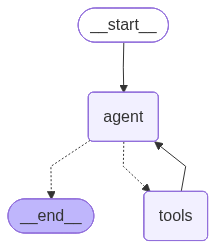

In [61]:
from IPython.display import Image, display

Image(app.get_graph().draw_mermaid_png())

In [63]:

from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(
            content="What is the current stock price of NVIDIA (NVDA) and what is the latest news about the company?"
            )
        ],
    "performance_log": []
}

response = app.invoke(inputs)
response["messages"][-1].content

--- AGENT: Invoking LLM --- 
Agent response: content='' additional_kwargs={'tool_calls': [{'function': {'arguments': '{"symbol": "NVDA"}', 'name': 'get_stock_price', 'description': None}, 'id': 'chatcmpl-tool-08c342a0d74c4f61a45553e3dce8adc1', 'type': 'function'}, {'function': {'arguments': '{"company_name": "NVIDIA"}', 'name': 'get_recent_company_news', 'description': None}, 'id': 'chatcmpl-tool-9b915f5454f34eb588ef06a7b4bc4169', 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 247, 'total_tokens': 293}, 'model_name': 'Qwen/Qwen3-4B-Instruct-2507', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run--a8c41e0a-0d89-4897-9817-9bbec2cb17cd-0' tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'NVDA'}, 'id': 'chatcmpl-tool-08c342a0d74c4f61a45553e3dce8adc1', 'type': 'tool_call'}, {'name': 'get_recent_company_news', 'args': {'company_name': 'NVIDIA'}, 'id': 'chatcmpl-tool-9b915f5454f34eb588ef06a7b4bc4

"The current stock price of NVIDIA (NVDA) is **$184.65**.\n\nHere is the latest news about NVIDIA:\n\n1. **The Largest Digital Zoo: Biology Model Trained on NVIDIA GPUs Identifies Over a Million Species**  \n   A biology model trained on NVIDIA GPUs has successfully identified over a million species, demonstrating the power of AI in scientific research.\n\n2. **Ultimate Cloud Gaming Is Everywhere With GeForce NOW**  \n   NVIDIA's GeForce NOW continues to expand its cloud gaming platform, making high-quality gaming accessible from anywhere.\n\n3. **NVIDIA Announces Financial Results for Third Quarter Fiscal 2026**  \n   NVIDIA has released its financial results for Q3 fiscal 2026, highlighting strong performance and continued growth in AI and data center markets.\n\n4. **Gordon Bell Prize Winners Push Open Science Boundaries With NVIDIA-Powered Supercomputers**  \n   Researchers using NVIDIA-powered supercomputers have made significant breakthroughs in open science, enabling complex sim

In [66]:
import json
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

inputs = {
    "messages": [HumanMessage(content="What is the current stock price of NVIDIA (NVDA) and what is the latest news about the company?")],
    "performance_log": []
}

step_counter = 1
final_state = None

for output in app.stream(inputs, stream_mode="values"):
    # With stream_mode="values", output IS the full state directly
    # NOT {node_name: state}
    
    print(f"\n{'*' * 100}")
    print(f"**Step {step_counter}**")
    print(f"{'*' * 100}")
    
    # output is the state dict with keys like 'messages', 'performance_log'
    messages = output.get("messages", [])
    performance_log = output.get("performance_log", [])
    
    print(f"\nMessages count: {len(messages)}")
    print(f"Performance log: {performance_log}")
    
    # Analyze the last message
    if messages:
        last_msg = messages[-1]
        print(f"\nLast message type: {type(last_msg).__name__}")
        
        if isinstance(last_msg, HumanMessage):
            print(f"Human: {last_msg.content}")
        elif isinstance(last_msg, AIMessage):
            if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
                print("Agent planned tool calls:")
                for tc in last_msg.tool_calls:
                    print(f"  - {tc['name']}({tc['args']})")
            else:
                print(f"Agent final response: {last_msg.content[:200]}...")
        elif isinstance(last_msg, ToolMessage):
            print(f"Tool result [{last_msg.name}]: {last_msg.content[:100]}...")
    
    print(f"\n{'-' * 100}")
    step_counter += 1
    final_state = output

print(f"\n{'=' * 100}")
print("FINAL ANSWER")
print(f"{'=' * 100}")
if final_state and final_state.get("messages"):
    print(final_state["messages"][-1].content)


****************************************************************************************************
**Step 1**
****************************************************************************************************

Messages count: 1
Performance log: []

Last message type: HumanMessage
Human: What is the current stock price of NVIDIA (NVDA) and what is the latest news about the company?

----------------------------------------------------------------------------------------------------
--- AGENT: Invoking LLM --- 
Agent response: content='' additional_kwargs={'tool_calls': [{'function': {'arguments': '{"symbol": "NVDA"}', 'name': 'get_stock_price', 'description': None}, 'id': 'chatcmpl-tool-434b867f064d4123909b5ecc66549934', 'type': 'function'}, {'function': {'arguments': '{"company_name": "NVIDIA"}', 'name': 'get_recent_company_news', 'description': None}, 'id': 'chatcmpl-tool-b488d1b396af4092a915eeeb27c7dbc8', 'type': 'function'}]} response_metadata={'token_usage': {'completion_token

In [70]:
print("Run Log:")
total_time = 0
tool_time = 0
for log in final_state['performance_log']:
    print(f" - {log}")
    # Extract the time value from the log string.
    time_val = float(log.content.split(' ')[-2])
    total_time += time_val
    if "[TOOLS]" in log:
        tool_time = time_val
print("\n" + "-"*60 + "\n")
print(f"Total Execution Time: {total_time:.2f} seconds\n")

Run Log:
 - content='[AGENT] LLM call took 1.41 seconds.' additional_kwargs={} response_metadata={} id='373833b4-f480-4d3a-8d37-bfe42e2055be'
 - content='[TOOLS] Executed 2 tools in 2.20 seconds.' additional_kwargs={} response_metadata={} id='4ead0485-e637-4499-9ba0-4e900618615d'
 - content='[AGENT] LLM call took 6.24 seconds.' additional_kwargs={} response_metadata={} id='ccac4efd-7c8f-41e1-a6ee-9de7f156a6fd'

------------------------------------------------------------

Total Execution Time: 9.85 seconds



The total time for the tool execution step was 2.20 seconds. Let’s assume each individual network call took ~1.5 seconds. A sequential execution would have taken ~3.0 seconds (1.5s + 1.5s).

Our parallel approach saved ~0.8 seconds. This gain seems small, in a more complex system with 5–10 independent tool calls, each taking 2–3 seconds, the difference is going to be more higher. A sequential process would take 10–30 seconds, while a parallel one would still take only 2–3 seconds. This is the difference between a usable system and an unusable one.